In [ ]:
!pip install lightning grad-cam

In [ ]:
! ls

In [ ]:
! unzip drive/MyDrive/archive.zip

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
class MyDataset(Dataset):
  def __init__(self,path,transform=None) -> None:
    super().__init__()
    data=pd.read_csv(path)
    self.data=data[data['Frontal/Lateral']==('Frontal')]
    self.data=self.data.reset_index(drop=True).T.fillna(0.0)
    self.transform = transform
  
  def __getitem__(self, index):
    item=self.data[index]
    labels=1.0*(item[5:].to_numpy(dtype=float)>0)
    path_to_img=item[0]
    image=Image.open(path_to_img)
    if self.transform is not None:
      image=self.transform(image)
    return image,labels

  def __len__(self):
    return len(self.data.T)


In [4]:
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)])

In [5]:
train_ds=MyDataset('/content/CheXpert-v1.0-small/train.csv',transform)
val_ds=MyDataset('/content/CheXpert-v1.0-small/valid.csv',transform)

In [6]:
idx=list(pd.read_csv('/content/CheXpert-v1.0-small/valid.csv').T.index[5:])
idx

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [7]:
batch_size=512

train_dl = DataLoader(train_ds,batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size,shuffle=False)

In [8]:
class MyModel(pl.LightningModule):
  def __init__(self,lr=1e-2):
    super(MyModel,self).__init__()
    
    model=torchvision.models.mobilenet_v3_small()
    model.features[0][0]=nn.Conv2d(1,16,(3,3),stride=(2,2),padding=(1,1),bias=False)
    model.classifier[3]=nn.Linear(1024,14)
    self.model=model
    self.learning_rate=1e-3
  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    X,Y = batch
    Y_hat = self.forward(X)
    loss = torch.nn.BCEWithLogitsLoss()(Y_hat,Y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    X,Y = batch
    Y_hat = self.forward(X)
    loss = torch.nn.BCEWithLogitsLoss()(Y_hat,Y)
    self.log("val_loss", loss, prog_bar=True)
    return loss

  def configure_optimizers(self):
    optimizer =  torch.optim.AdamW(self.parameters(), lr=self.learning_rate,weight_decay=1e-2)
    return {
        "optimizer": optimizer,
        #"lr_scheduler": {
        #    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2,threshold=1e-1,verbose=True),
        #    "interval": "epoch",
        #    "frequency": 1,
        #    "monitor": "val_loss"},
    }

model=MyModel()
model

MyModel(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNorm

In [9]:
trainer=pl.Trainer(accelerator="gpu",
                   max_epochs=10,
                   callbacks=[EarlyStopping(monitor="val_loss", mode="min",min_delta = 0.02 ,patience = 0)],
                   #auto_lr_find=True,
                   #profiler="simple"
                   )
#trainer.tune(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params
--------------------------------------
0 | model | MobileNetV3 | 1.5 M 
--------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.128     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type        | Params
-------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
target_layers = [model.model.features[-1]]

In [11]:
explain_dl = DataLoader(train_ds,1,shuffle=False)

In [12]:
input_image=next(iter(explain_dl))[0]

In [13]:
model.eval()
cam = GradCAM(model=nn.Sequential(model,nn.Sigmoid()), target_layers=target_layers, use_cuda=True)

In [14]:
def visualise(cams,input_image):
  display(transforms.ToPILImage()(np.concatenate(list(map(lambda x: show_cam_on_image(torch.stack(3*[input_image[0][0]],dim=-1).numpy(), x[0], use_rgb=True),cams)),axis=1)))

In [15]:
def generate_and_visualise(explain_dl_iter=iter(explain_dl),cam=cam):
  input_image,labels=next(explain_dl_iter)

  cams_per_category=[]
  for i in range(14):
    targets = [ClassifierOutputTarget(i)]
    category_cams = cam(input_tensor=input_image, targets=targets)
    cams_per_category.append(category_cams)

  visualise(cams_per_category,input_image)
  df=pd.DataFrame(np.stack([labels.numpy()[0],
                  (nn.Sigmoid()(model(input_image.to('cuda'))).detach().cpu().numpy()[0]) 
                  ]))
  df.columns=idx
  display(df)

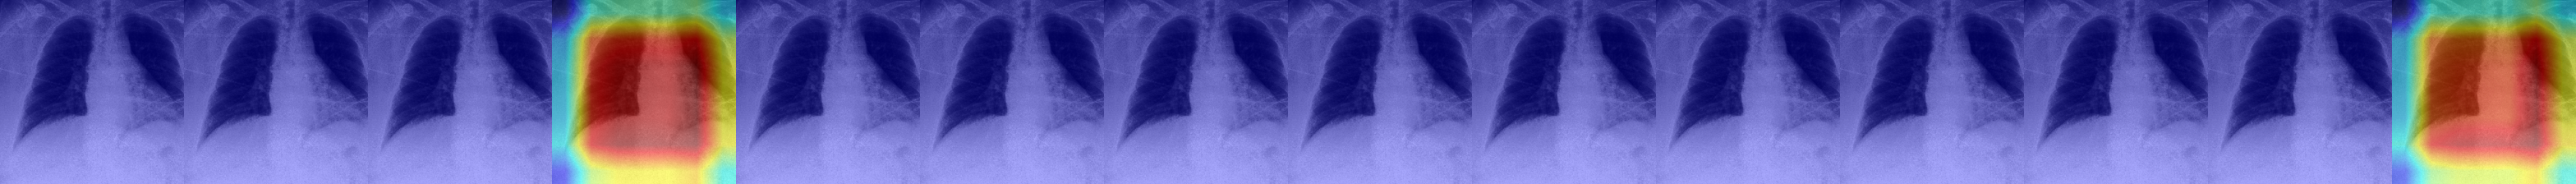

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
1,0.454172,0.430811,0.471978,0.510628,0.421179,0.47709,0.451173,0.418341,0.481172,0.466462,0.489738,0.395486,0.42137,0.508605


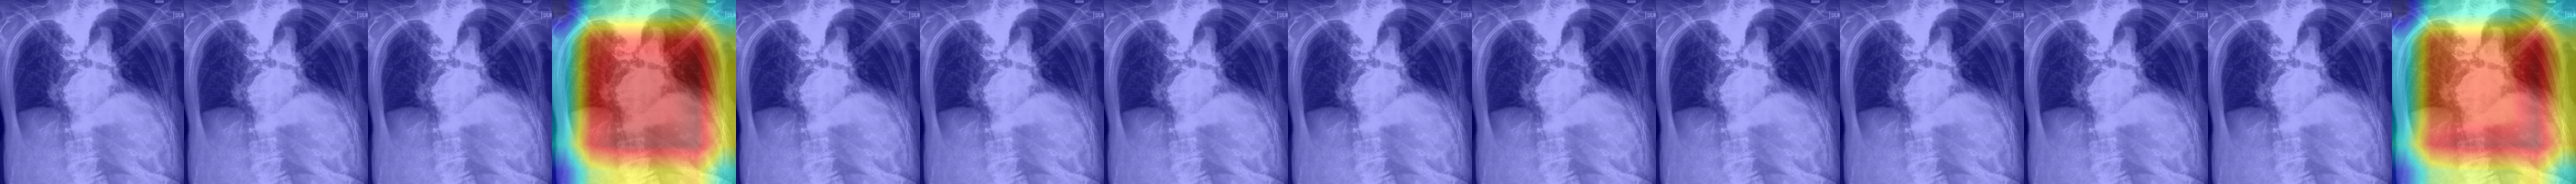

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
1,0.454172,0.430811,0.471978,0.510628,0.421179,0.47709,0.451173,0.418341,0.481172,0.466462,0.489738,0.395486,0.42137,0.508605


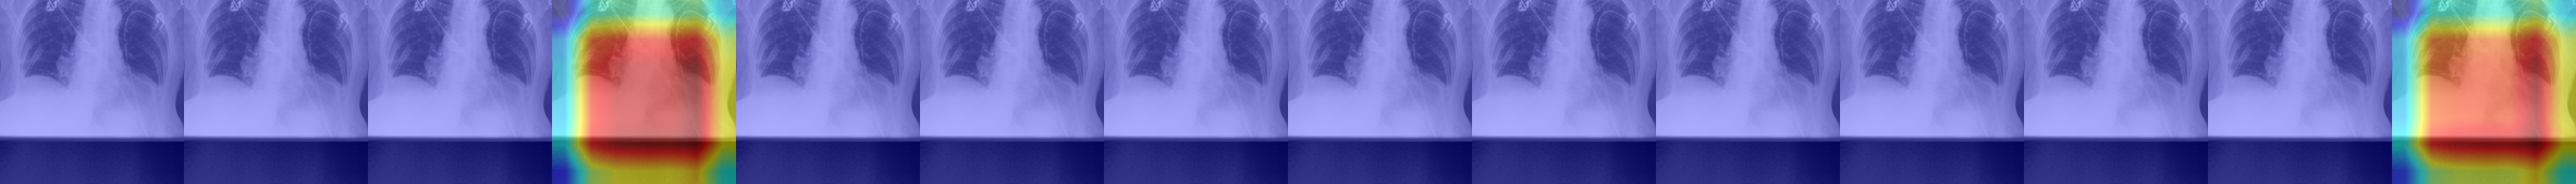

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
1,0.454172,0.430811,0.471978,0.510628,0.421179,0.47709,0.451173,0.418341,0.481172,0.466462,0.489738,0.395486,0.42137,0.508605


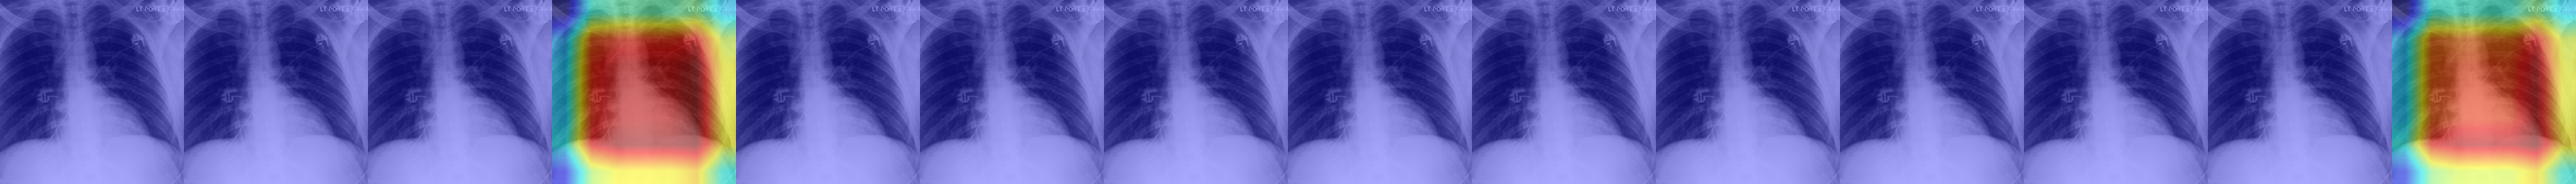

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.454172,0.430811,0.471978,0.510628,0.421179,0.47709,0.451173,0.418341,0.481172,0.466462,0.489738,0.395486,0.42137,0.508605


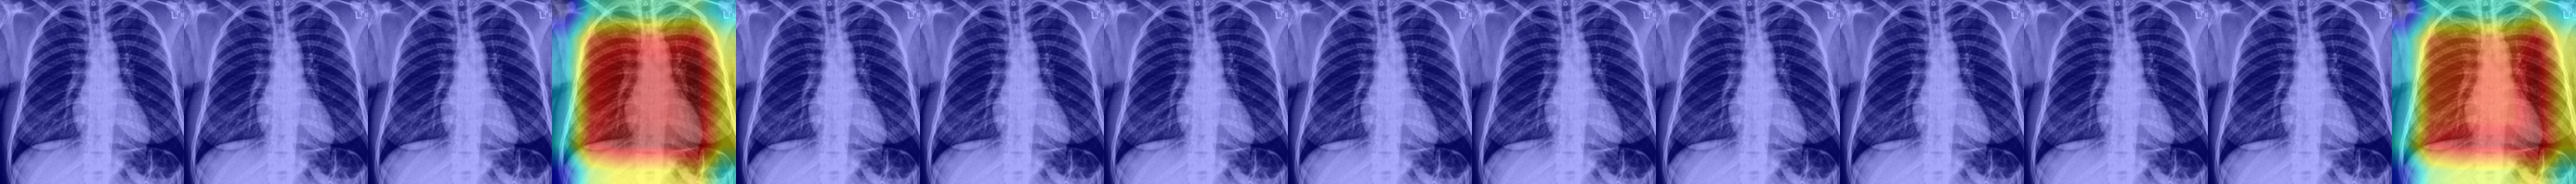

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.454172,0.430811,0.471978,0.510628,0.421179,0.47709,0.451173,0.418341,0.481172,0.466462,0.489738,0.395486,0.42137,0.508605


In [16]:
for i in range(5):
  generate_and_visualise()